In [1]:
from tensorflow import keras

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet", include_top=False, input_shape=(180, 180, 3)
)
conv_base.summary()


2022-10-06 14:03:16.663915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-06 14:03:16.814638: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-06 14:03:17.438617: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-06 14:03:17.438702: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [2]:
import os
import shutil
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory

new_base_dir = pathlib.Path(os.path.join("..", "..", "dataset", "cats_vs_dogs_small"))


image_size = (180, 180)
batch_size = 32
train_dataset = image_dataset_from_directory(
    new_base_dir / "train", image_size=image_size, batch_size=batch_size
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation", image_size=image_size, batch_size=batch_size
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test", image_size=image_size, batch_size=batch_size
)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [3]:
import numpy as np


def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)


train_features, train_labels = get_features_and_labels(train_dataset)
validation_features, validation_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)
train_features.shape


2022-10-06 14:03:24.037579: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-10-06 14:03:24.655843: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 29ms/step


(2000, 5, 5, 512)

In [4]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 5, 512)]       0         
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 256)               3277056   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3,277,313
Trainable params: 3,277,313
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])


In [6]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras", save_best_only=True, monitor="val_loss"
    )
]


In [7]:
history = model.fit(
    train_features,
    train_labels,
    epochs=20,
    validation_data=(validation_features, validation_labels),
    callbacks=callbacks,
)


Epoch 1/20
63/63 [==============================] - 1s 14ms/step - loss: 18.3182 - accuracy: 0.9190 - val_loss: 10.2812 - val_accuracy: 0.9560
Epoch 2/20
63/63 [==============================] - 1s 11ms/step - loss: 3.5870 - accuracy: 0.9785 - val_loss: 12.1646 - val_accuracy: 0.9470
Epoch 3/20
63/63 [==============================] - 1s 13ms/step - loss: 2.5362 - accuracy: 0.9835 - val_loss: 6.3871 - val_accuracy: 0.9670
Epoch 4/20
63/63 [==============================] - 1s 14ms/step - loss: 0.7765 - accuracy: 0.9940 - val_loss: 5.8499 - val_accuracy: 0.9720
Epoch 5/20
63/63 [==============================] - 1s 14ms/step - loss: 1.3811 - accuracy: 0.9885 - val_loss: 9.7962 - val_accuracy: 0.9580
Epoch 6/20
63/63 [==============================] - 1s 14ms/step - loss: 1.4335 - accuracy: 0.9925 - val_loss: 5.5337 - val_accuracy: 0.9750
Epoch 7/20
63/63 [==============================] - 1s 14ms/step - loss: 0.4520 - accuracy: 0.9945 - val_loss: 4.9339 - val_accuracy: 0.9750
Epoch 8/20

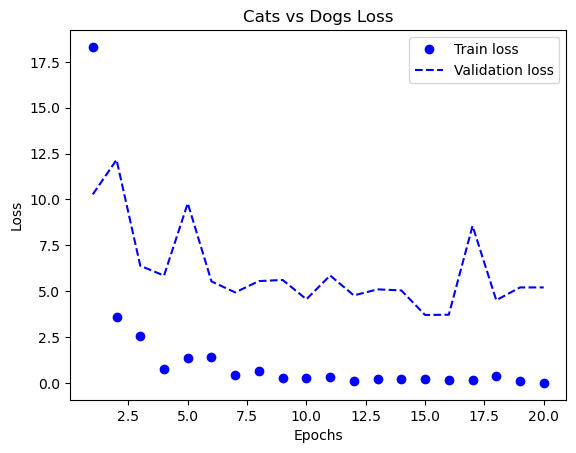

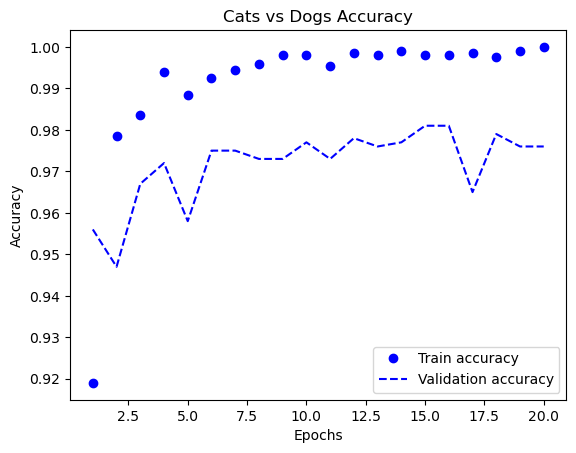

In [9]:
import matplotlib.pyplot as plt

epoch_range = range(1, 21)
plt.plot(epoch_range, history.history["loss"], "bo", label="Train loss")
plt.plot(epoch_range, history.history["val_loss"], "b--", label="Validation loss")
plt.title("Cats vs Dogs Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.figure()
plt.plot(epoch_range, history.history["accuracy"], "bo", label="Train accuracy")
plt.plot(epoch_range, history.history["val_accuracy"], "b--", label="Validation accuracy")
plt.title("Cats vs Dogs Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()